In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import time

In [2]:
window_size = 24

In [3]:
df = pd.read_csv("./data/clean_data.csv")
df.set_index("Date", inplace = True)
df = df.head(-16)
df.tail(10)

,Ta (°C),Tm (°C),I15 (W/m2),P (kW)
Date,,,,
2013-12-30 21:00:00,10.1915,7.280667,0.0,0.0
2013-12-30 22:00:00,0.0000,0.000000,0.0,0.0
2013-12-30 23:00:00,0.0000,0.000000,0.0,0.0
2013-12-31 00:00:00,0.0000,0.000000,0.0,0.0
2013-12-31 01:00:00,0.0000,0.000000,0.0,0.0
2013-12-31 02:00:00,0.0000,0.000000,0.0,0.0
2013-12-31 03:00:00,0.0000,0.000000,0.0,0.0
2013-12-31 04:00:00,0.0000,0.000000,0.0,0.0
2013-12-31 05:00:00,0.0000,0.000000,0.0,0.0


In [4]:
df.index = pd.to_datetime(df.index)

In [5]:
df.index

DatetimeIndex(['2012-03-06 04:00:00', '2012-03-06 05:00:00',
               '2012-03-06 06:00:00', '2012-03-06 07:00:00',
               '2012-03-06 08:00:00', '2012-03-06 09:00:00',
               '2012-03-06 10:00:00', '2012-03-06 11:00:00',
               '2012-03-06 12:00:00', '2012-03-06 13:00:00',
               ...
               '2013-12-30 21:00:00', '2013-12-30 22:00:00',
               '2013-12-30 23:00:00', '2013-12-31 00:00:00',
               '2013-12-31 01:00:00', '2013-12-31 02:00:00',
               '2013-12-31 03:00:00', '2013-12-31 04:00:00',
               '2013-12-31 05:00:00', '2013-12-31 06:00:00'],
              dtype='datetime64[ns]', name='Date', length=15963, freq=None)

In [6]:
# univariate forecasting
df = df[["P (kW)"]]
df.head(5)

,P (kW)
Date,
2012-03-06 04:00:00,0.000000
2012-03-06 05:00:00,0.000000
2012-03-06 06:00:00,14.752650
2012-03-06 07:00:00,127.163083
2012-03-06 08:00:00,302.455700


In [7]:
train = df[:-24]

In [8]:
test = df[-24:]

In [9]:
def create_dataset(df, time_steps=24):
    """
    Convert univariate time series dataset into a dataset with past 24 timesteps as input
    and the next timestep as output.

    Parameters:
    - df (DataFrame): Input DataFrame with 'Power' column and datetime index.
    - time_steps (int): Number of past timesteps to consider for input features.

    Returns:
    - X (DataFrame): Input features with past timesteps.
    - y (Series): Output (next timestep).
    """
    # Create shifted columns for past timesteps
    for i in range(1, time_steps + 1):
        df[f'P (kW)_t-{i}'] = df['P (kW)'].shift(i)

    # Drop rows with NaN values
    df.dropna(inplace=True)

    # Separate input features (X) and output (y)
    X = df.drop(columns=['P (kW)'])
    Y = df['P (kW)']

    return X, Y

In [10]:
X, Y = create_dataset(train, 24)

C:\Users\itadmin\AppData\Local\Temp\ipykernel_22088\3470829352.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'P (kW)_t-{i}'] = df['P (kW)'].shift(i)
C:\Users\itadmin\AppData\Local\Temp\ipykernel_22088\3470829352.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'P (kW)_t-{i}'] = df['P (kW)'].shift(i)
C:\Users\itadmin\AppData\Local\Temp\ipykernel_22088\3470829352.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [11]:
# Split data into train and validation sets
test_size = 0.2
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=test_size, shuffle=False)

## XGB

In [12]:
xgb = xgb.XGBRegressor(objective ='reg:squarederror')

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           verbose=1)

start_time = time.time()
grid_search.fit(X_train, Y_train)
total_time = time.time() - start_time
best_params = grid_search.best_params_
best_xgb_regressor = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [13]:
last_24_values_test = Y_val[-window_size:].values.reshape(1, -1)
predictions_test = []

for i in range(window_size):
    # Make the prediction
    pred_test = best_xgb_regressor.predict(last_24_values_test)
    
    # Store the prediction
    predictions_test.append(pred_test[0])
    
    # Shift the values to the left and add the predicted value to the last_24_values_test for the next iteration
    last_24_values_test = np.append(last_24_values_test[:, 1:], pred_test).reshape(1, -1)

In [14]:
mse_test = mean_squared_error(test, predictions_test)
rmse_test = np.sqrt(mse_test)

In [15]:
# Generate report
print("Report:")
print(f"RMSE on Test Set: {rmse_test}")
print(f"Total Training Time: {total_time:.2f} seconds")
print(f"Best Hyperparameters: {best_params}")

Report:
RMSE on Test Set: 64.33999695769596
Total Training Time: 86.45 seconds
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}


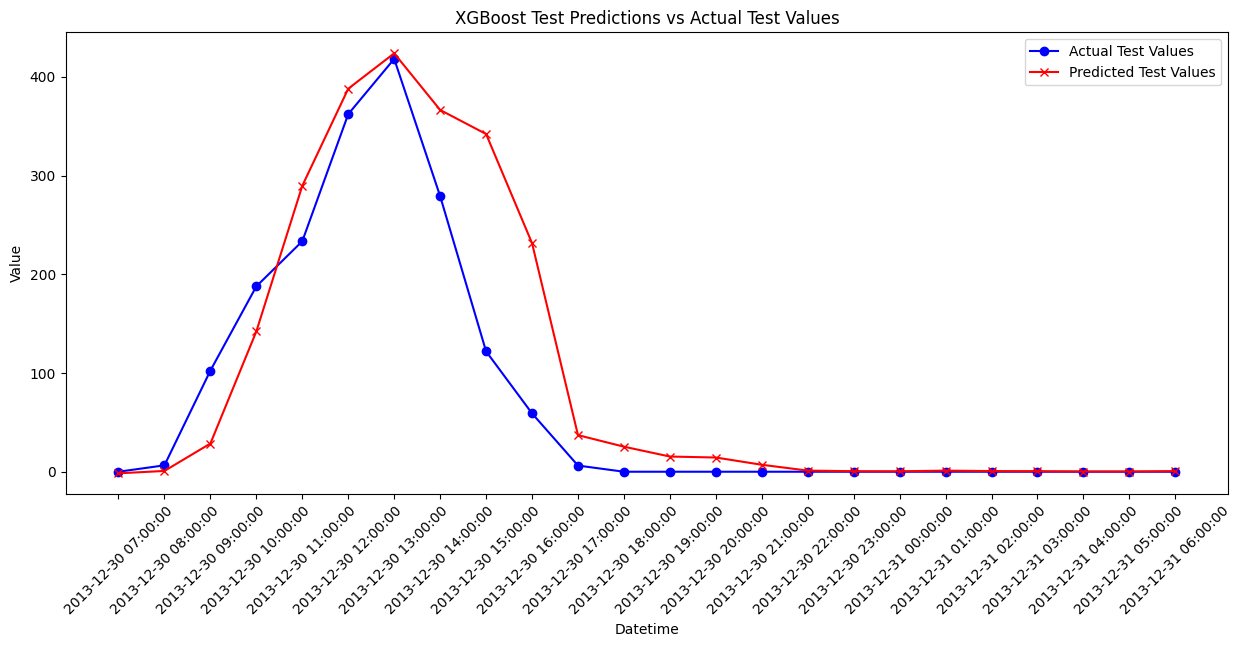

In [16]:
plt.figure(figsize=(15, 6))
plt.plot(test.index[-window_size:], test.values[-window_size:], label='Actual Test Values', marker='o', color='blue')
plt.plot(test.index[-window_size:], predictions_test, label='Predicted Test Values', marker='x', color='red')
plt.title('XGBoost Test Predictions vs Actual Test Values')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

# Set x-axis ticks to match the date range
plt.xticks(test.index[-window_size:], rotation=45)

plt.show()

## LightGB

In [17]:
lgb = LGBMRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(estimator=lgb,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           verbose=1)

start_time = time.time()
grid_search.fit(X_train, Y_train)
total_time = time.time() - start_time
best_params = grid_search.best_params_
best_lgb_regressor = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 10185, number of used features: 24
[LightGBM] [Info] Start training from score 164.922164
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 10185, number of used features: 24
[LightGBM] [Info] Start training from score 170.137964
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM]

In [18]:
last_24_values_test = Y_val[-window_size:].values.reshape(1, -1)
predictions_test = []

for i in range(window_size):
    # Make the prediction
    pred_test = best_lgb_regressor.predict(last_24_values_test)
    
    # Store the prediction
    predictions_test.append(pred_test[0])
    
    # Shift the values to the left and add the predicted value to the last_24_values_test for the next iteration
    last_24_values_test = np.append(last_24_values_test[:, 1:], pred_test).reshape(1, -1)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

In [19]:
mse_test = mean_squared_error(test, predictions_test)
rmse_test = np.sqrt(mse_test)

In [20]:
# Generate report
print("Report:")
print(f"RMSE on Test Set: {rmse_test}")
print(f"Total Training Time: {total_time:.2f} seconds")
print(f"Best Hyperparameters: {best_params}")

Report:
RMSE on Test Set: 61.38704600731675
Total Training Time: 38.82 seconds
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.6}


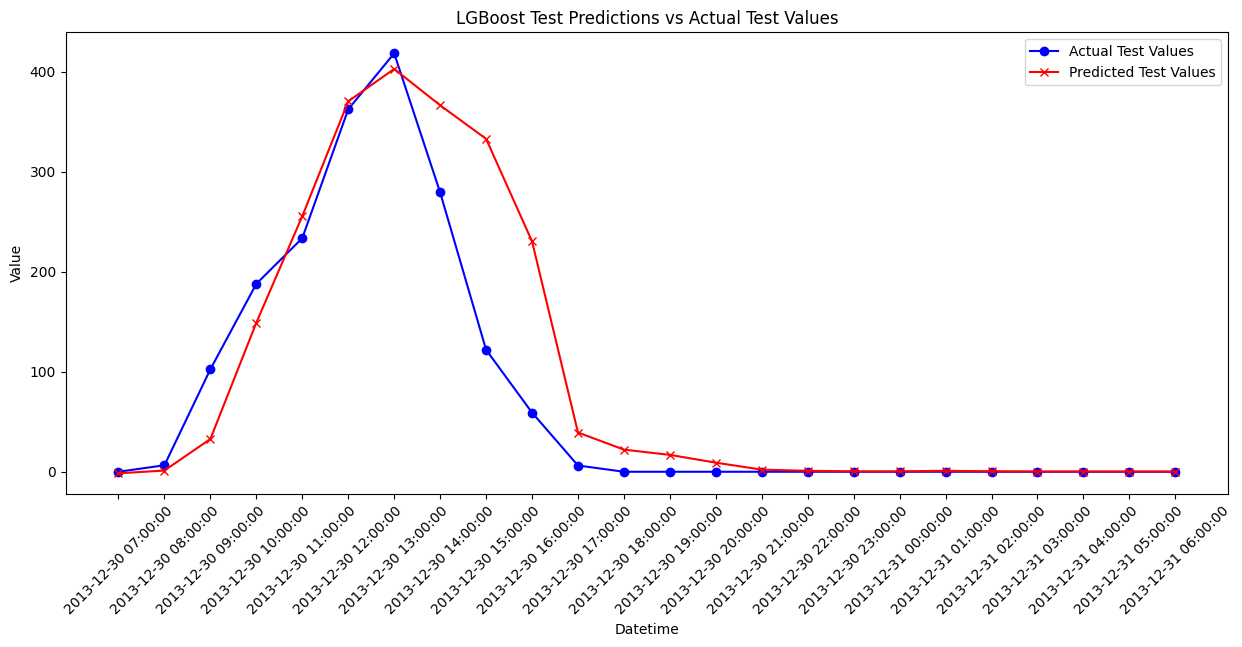

In [21]:
plt.figure(figsize=(15, 6))
plt.plot(test.index[-window_size:], test.values[-window_size:], label='Actual Test Values', marker='o', color='blue')
plt.plot(test.index[-window_size:], predictions_test, label='Predicted Test Values', marker='x', color='red')
plt.title('LGBoost Test Predictions vs Actual Test Values')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

# Set x-axis ticks to match the date range
plt.xticks(test.index[-window_size:], rotation=45)

plt.show()

## AdaBoost

In [28]:
ab = AdaBoostRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'loss': ['linear', 'square', 'exponential']
}

grid_search = GridSearchCV(estimator=ab,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           verbose=1)

start_time = time.time()
grid_search.fit(X_train, Y_train)
total_time = time.time() - start_time
best_params = grid_search.best_params_
best_abr_regressor = grid_search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [29]:
mse_test = mean_squared_error(test, predictions_test)
rmse_test = np.sqrt(mse_test)

In [30]:
# Generate report
print("Report:")
print(f"RMSE on Test Set: {rmse_test}")
print(f"Total Training Time: {total_time:.2f} seconds")
print(f"Best Hyperparameters: {best_params}")

Report:
RMSE on Test Set: 61.38704600731675
Total Training Time: 872.86 seconds
Best Hyperparameters: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 50}


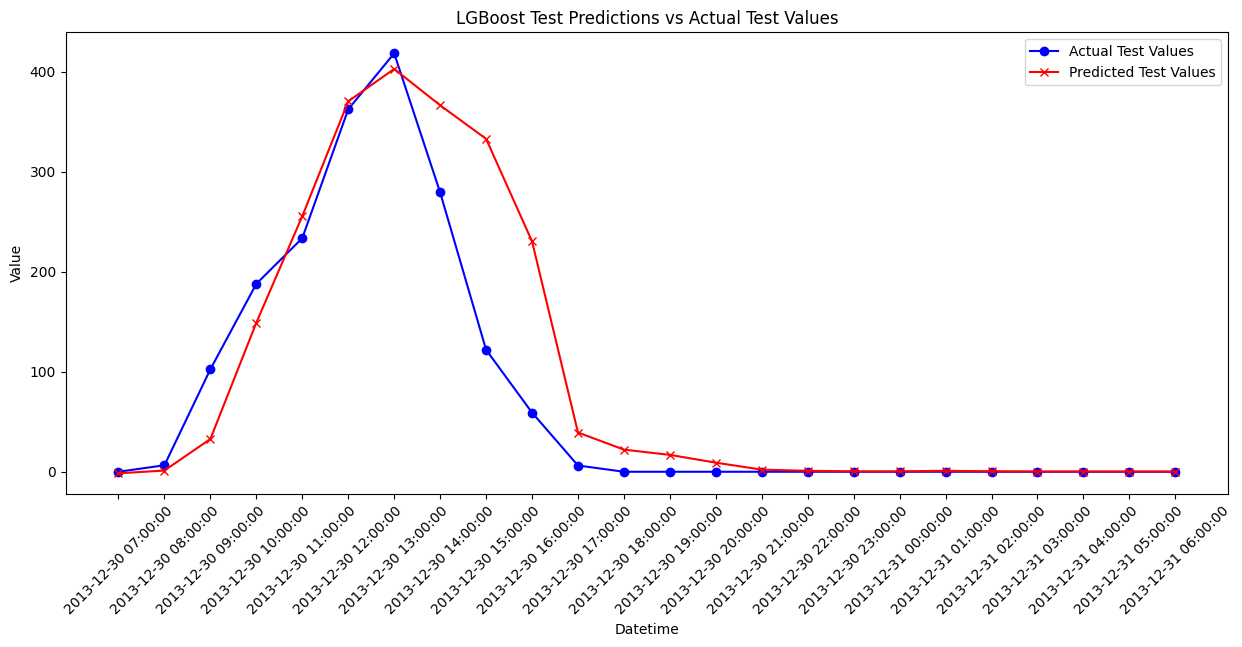

In [31]:
plt.figure(figsize=(15, 6))
plt.plot(test.index[-window_size:], test.values[-window_size:], label='Actual Test Values', marker='o', color='blue')
plt.plot(test.index[-window_size:], predictions_test, label='Predicted Test Values', marker='x', color='red')
plt.title('LGBoost Test Predictions vs Actual Test Values')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

# Set x-axis ticks to match the date range
plt.xticks(test.index[-window_size:], rotation=45)

plt.show()